<h2 style='text-align: center;'>AIPM -  MiniProject - CH22M503</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>


<h2 style='text-align: center;'>Kalman Filter - 1st Version</h2>

#### Importing Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
    - Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
    - Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

#### Reference used 

#### Loading the data

In [4]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
display(tank_measurement_data)

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145
...,...,...,...,...
9996,12.262968,12.783158,1.633941,1.409045
9997,12.262968,12.783158,1.633941,1.409045
9998,12.262968,12.783158,1.633941,1.409045
9999,12.262968,12.783158,1.633941,1.409045


#### Seperate each tank measurement 

In [5]:
# Separate the measurements for each tank
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [6]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


#### Common variable declaration

In [7]:
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
time_steps_10000 = np.arange(len(tank1_measurements) - 1)
# Measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
# Variable holding the number of tanks for this excercise
num_tanks = measurements.shape[1]
# Number of measurement availables
num_measurements = len(measurements)
# Initialize lists to store values for plotting
X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list = [],[],[],[],[]
# Flag to track L2 norm convergence
l2_norm_converged = False  

#### Variable declaration for - Kalman Filter

In [8]:
# Simulation of Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero
# Karl Henrik Johansson. Parameter Initialization

# Base variables required for further parameter initialization
h = tank_measurement_data.to_numpy()[0,:]
Ar = [28, 32, 28, 32]
ar = [0.071, 0.057, 0.071, 0.057]
g = 981.2
gamma_1, gamma_2= 0.7, 0.6
k1, k2 = 3.33, 3.35
kc=0.5

#Time constant measurement
T = [(Ar[i] / ar[i]) * np.sqrt((2 * h[i]) / g) for i in range(len(h))]
#State transtion matrix
state_transition_matrix = np.array([[-1 / T[0], 0, Ar[2] / (Ar[0] * T[2]), 0], [0, -1 / T[1], 0, Ar[3] / (Ar[1] * T[3])], [0, 0, -1 / T[2], 0], [0, 0, 0, -1 / T[3]]])
#Control input measurement
control_input = np.array([[3], [3]])
control_input_matrix = np.array([[(gamma_1 * k1) / Ar[0], 0], [0, (gamma_2 * k2) / Ar[1]], [0, ((1 - gamma_2) * k2) / Ar[2]], [((1 - gamma_1) * k1) / Ar[3], 0]])
# Initial state estimate
initial_state = np.ones((num_tanks, 1)) 
# Initial error covariance
initial_error_covariance = 1e5 * np.eye(num_tanks)  
# Measurement noise covariance - Hyperparameter
measurement_noise_cov = 2 * np.eye(2) 
#Observation Matrix
observation_matrix = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])

#Print Statements
print(f'Time Constant : \n{T}')
print(f'state_transition_matrix :\n{state_transition_matrix}')
print(f'control_input_matrix :\n{control_input_matrix}')
print(f'initial_state :\n{initial_state.T}')
print(f'observation_matrix :\n{observation_matrix}')
print(f'initial_error_covariance :\n{initial_error_covariance}')
print(f'measurement_noise_cov :\n{measurement_noise_cov}')

Time Constant : 
[62.69699892820124, 90.32609002462239, 23.887580479237094, 29.989924232904087]
state_transition_matrix :
[[-0.01594973  0.          0.04186276  0.        ]
 [ 0.         -0.011071    0.          0.03334453]
 [ 0.          0.         -0.04186276  0.        ]
 [ 0.          0.          0.         -0.03334453]]
control_input_matrix :
[[0.08325    0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.03121875 0.        ]]
initial_state :
[[1. 1. 1. 1.]]
observation_matrix :
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]
initial_error_covariance :
[[100000.      0.      0.      0.]
 [     0. 100000.      0.      0.]
 [     0.      0. 100000.      0.]
 [     0.      0.      0. 100000.]]
measurement_noise_cov :
[[2. 0.]
 [0. 2.]]


#### Common function

In [9]:
def kalman_filter_simulation(z, u, A, B, H, Q, R, P, x): 
    """
    Simulates a Kalman filter given the measurements and system parameters.

    Args:
        z (numpy.ndarray): Array of shape (num_measurements, num_features) containing the measurements.
        u (numpy.ndarray): Array of shape (num_measurements, num_inputs) containing the control inputs.
        A (numpy.ndarray): System dynamics matrix of shape (num_features, num_features).
        B (numpy.ndarray): Control matrix of shape (num_features, num_inputs).
        H (numpy.ndarray): Observation Measurement matrix of shape (num_measurements, num_features).
        Q (numpy.ndarray): Process noise covariance matrix of shape (num_features, num_features).
        R (numpy.ndarray): Measurement noise covariance matrix of shape (num_measurements, num_measurements).
        P (numpy.ndarray): Initial state covariance matrix of shape (num_features, num_features).
        x (numpy.ndarray): Initial state vector of shape (num_features,).

    Returns:
        Tuple: A tuple containing lists of estimated states, post-measurement state covariances,
        prior-measurement state covariances, Kalman gains and measurement error

    """
    # Number of measurements
    num_measurements = len(z)
    l2_norm_converged = False  # Flag to track L2 norm convergence
    X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list, measurement_error_list = [],[],[],[],[],[]
    for k in range(num_measurements):
        # Prediction step
        X_pri = np.dot(A, x) + np.dot(B, u[:].reshape(-1, 1)) # Prior state estimate
        P_pri = np.dot(np.dot(A, P), A.T) + Q # Prior state covariance
        X_prior_list.append(X_pri.flatten()) # Store prior state estimate  
        
        # Update step
        K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R)) # Kalman gain
        Z_est = np.dot(H, X_pri) # Estimated measurement        
        E = z[k,:2] - Z_est.flatten() # Measurement error         
        
        measurement_error_list.append(E) # List of measurement error
        initial_state = X_pri + np.dot(K, E.reshape(-1, 1)) # Updated state estimate
        P = P_pri - np.dot(np.dot(K, H), P_pri) # Updated state covariance
        x = initial_state # Updated the initial states
        
        # Append values to the lists
        X_post_list.append(initial_state.flatten()) # Store post-measurement state estimate
        P_post_list.append(np.trace(P)) # Store post-measurement state covariance
        P_pri_list.append(np.trace(P_pri)) # Store prior-measurement state covariance
        Kalman_gain_list.append(np.trace(K)) # Store Kalman gain
        
        # Calculate the L2 norm        
        l2_norm = np.linalg.norm(X_pri - initial_state)
        threshold = 5e-3
        l2_norm_converged = False
        
        if np.allclose(l2_norm, threshold) and not l2_norm_converged:
            print(f"L2 norm converges to threshold value at {k} iteration")
            l2_norm_converged = True
            break
    
    estimated_states = initial_state.flatten()  # Final estimated states
    print("Posterior states:", estimated_states)      
    # Return simulation results
    return X_post_list, X_prior_list, P_post_list, P_pri_list, Kalman_gain_list, measurement_error_list

def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.plot(time_steps, original_data, label='Original Data', color='#9A0EEA')  
    # Plot the filter results
    plt.plot(time_steps, filter_results, label='Filter Results', color='red')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='#76FF7B', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()
    
def plotSingularData(subplot_num, time_steps, data, marker, ylable, color):
    """
    Plot a singular dataset on a subplot within a figure.

    Parameters:
        subplot_num (int): The number of the subplot where the data will be plotted.
        time_steps (array-like): The time steps corresponding to the data points.
        data (array-like): The data to be plotted.
        marker (str): The marker style for the data points.
        ylable (str): The label for the y-axis.
        color (str): The color for the data line and marker.

    Returns:
        None
    """
    # Defining the plot figure size
    plt.figure(figsize=(10, 5))
    # Adding the plot sup title 
    plt.suptitle(ylable, fontsize='20')
    # Create a subplot for the current tank
    plt.subplot(1, 1, subplot_num) 
    plt.plot(time_steps, data, label=ylable, color=color, marker=marker) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel(ylable) 
    # Show the legend
    plt.legend()
 

#### Looping through different combination of constant value to multiply with process noise covariance to see the best convergence for estimation

In [10]:
for hyperparameter in range(1,11,1):
    process_noise_cov = hyperparameter * np.eye(num_tanks)  # Process noise covariance 
    print(f'hyperparameter value {hyperparameter}')
    X_post_list_loop, X_prior_list_loop, _, _, _, _ = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, initial_error_covariance, initial_state)

hyperparameter value 1
Posterior states: [2.91549207 2.98449633 0.13324816 0.08759252]
hyperparameter value 2
Posterior states: [5.05249697 5.22493903 0.12959493 0.08515466]
hyperparameter value 3
Posterior states: [6.80483577 7.06091302 0.1265995  0.08315699]
hyperparameter value 4
Posterior states: [8.26780509 8.59288435 0.12409885 0.08149015]
hyperparameter value 5
Posterior states: [9.50762158 9.8905888  0.12197974 0.08007824]
hyperparameter value 6
Posterior states: [10.57172888 11.00394729  0.12016102  0.07886693]
hyperparameter value 7
Posterior states: [11.49501064 11.96963713  0.11858304  0.0778163 ]
hyperparameter value 8
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]
hyperparameter value 9
Posterior states: [13.01785649 13.56176738  0.11598046  0.07608417]
hyperparameter value 10
Posterior states: [13.6531672  14.22573778  0.11489474  0.07536183]


##### Explanation on choosing the process noise covariance value: 
- I have been tuning the hyperparameters to improve the accuracy of the estimation. Among the various hyperparameter values tested, a value of 8 has shown promising results, providing estimations that are close to the real values.

- Based on this observation, I have utilized this hyperparameter value as a multiplier term for the process noise covariance matrix. This modification aims to adjust the uncertainty in the system dynamics, considering the estimates of all four tanks.

#### Calling Kalman filter function for estimation with new process noise covariance matrix

In [11]:
process_noise_cov = 8 * np.eye(num_tanks)  # Process noise covariance
print(f'process_noise_cov : {process_noise_cov}')
X_post_list_loop, X_prior_list_loop, P_post_list_loop, P_pri_list_loop, Kalman_gain_list_loop, Measurement_error_loop = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, initial_error_covariance, initial_state)

process_noise_cov : [[8. 0. 0. 0.]
 [0. 8. 0. 0.]
 [0. 0. 8. 0.]
 [0. 0. 0. 8.]]
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]


In [12]:
X_post_list_loop = np.array(X_post_list_loop)
X_prior_list_loop = np.array(X_prior_list_loop)
P_post_list_loop = np.array(P_post_list_loop)
P_pri_list_loop = np.array(P_pri_list_loop)
Kalman_gain_list_loop = np.array(Kalman_gain_list_loop)

In [13]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_list_loop[:, 0] + h[0])}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_list_loop[:, 1] + h[1])}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_list_loop[:, 2] + h[2])}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_list_loop[:, 3] + h[3])}')

Tank 1 : Prior Estimate : 12.45830972770082
Tank 2 : Prior Estimate : 12.749072750727205
Tank 3 : Prior Estimate : 1.9387416703642066
Tank 4 : Prior Estimate : 1.4911540726631718


##### Based on the Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero Karl Henrik Johansson. Parameter Initialization
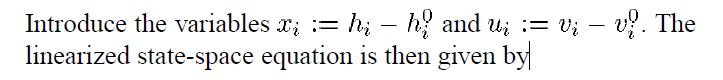

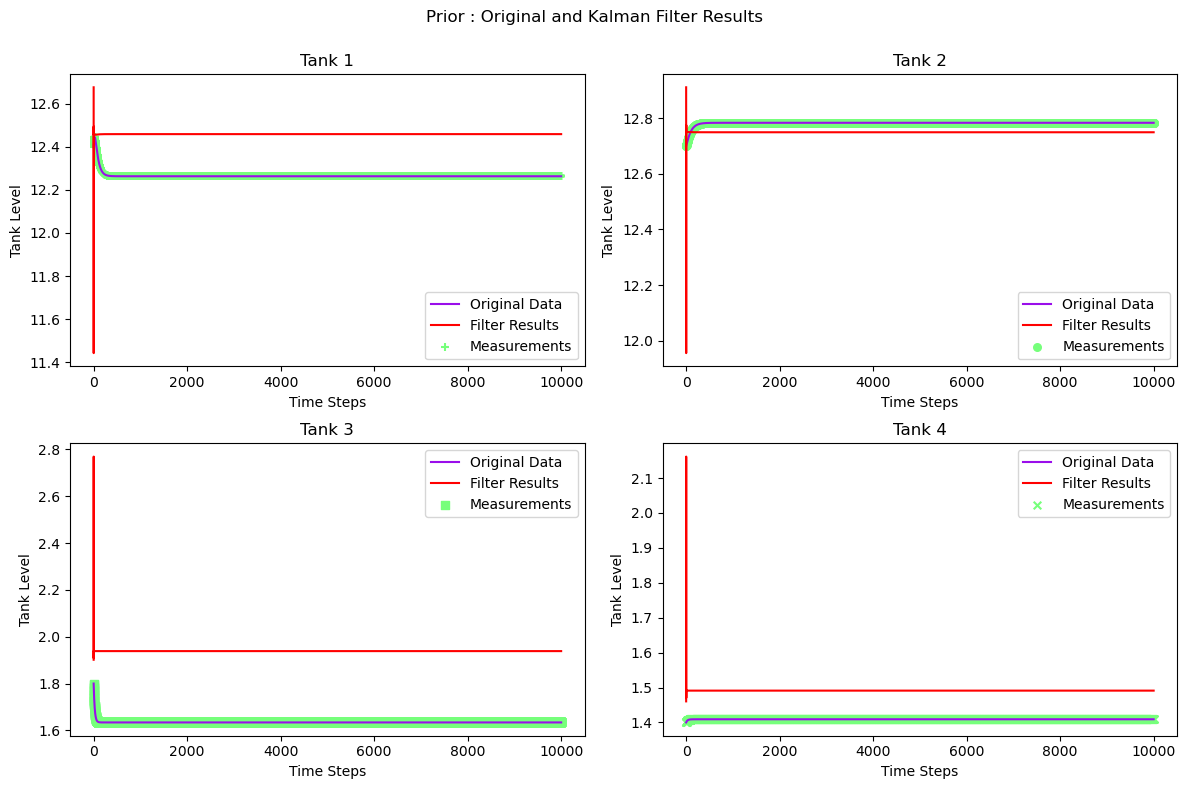

In [14]:
# Initialize the plot for Prior : Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_prior_list_loop[:, 0] + h[0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_prior_list_loop[:, 1] + h[1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_prior_list_loop[:, 2] + h[2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_prior_list_loop[:, 3] + h[3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [15]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_post_list_loop[:, 0])}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_post_list_loop[:, 1])}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_post_list_loop[:, 2])}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_post_list_loop[:, 3])}')

Tank 1 : Posterior Estimate : 12.306672148185898
Tank 2 : Posterior Estimate : 12.815466187393067
Tank 3 : Posterior Estimate : 0.11528296679472223
Tank 4 : Posterior Estimate : 0.0749478076157384


###### Posterior plots with entire data

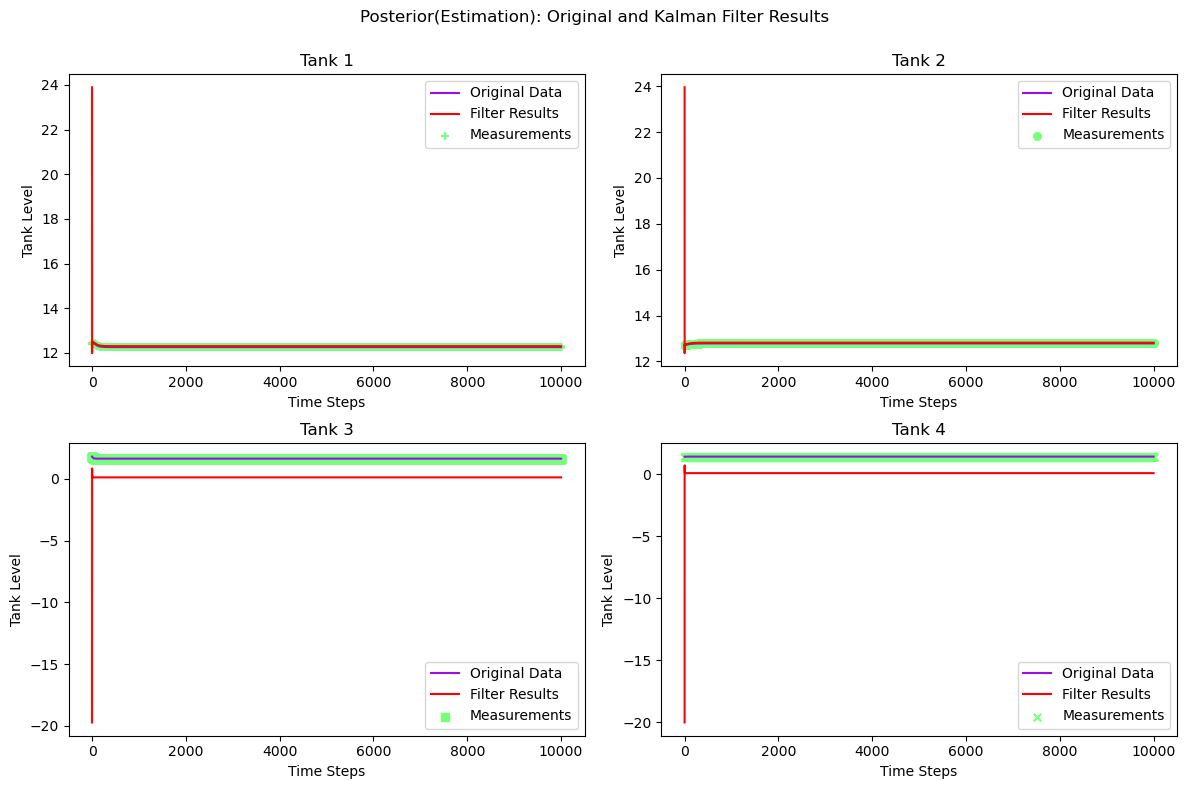

In [16]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_post_list_loop[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_post_list_loop[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_post_list_loop[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_post_list_loop[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Posterior plot after removing the first measurement to visualize the variation much closely

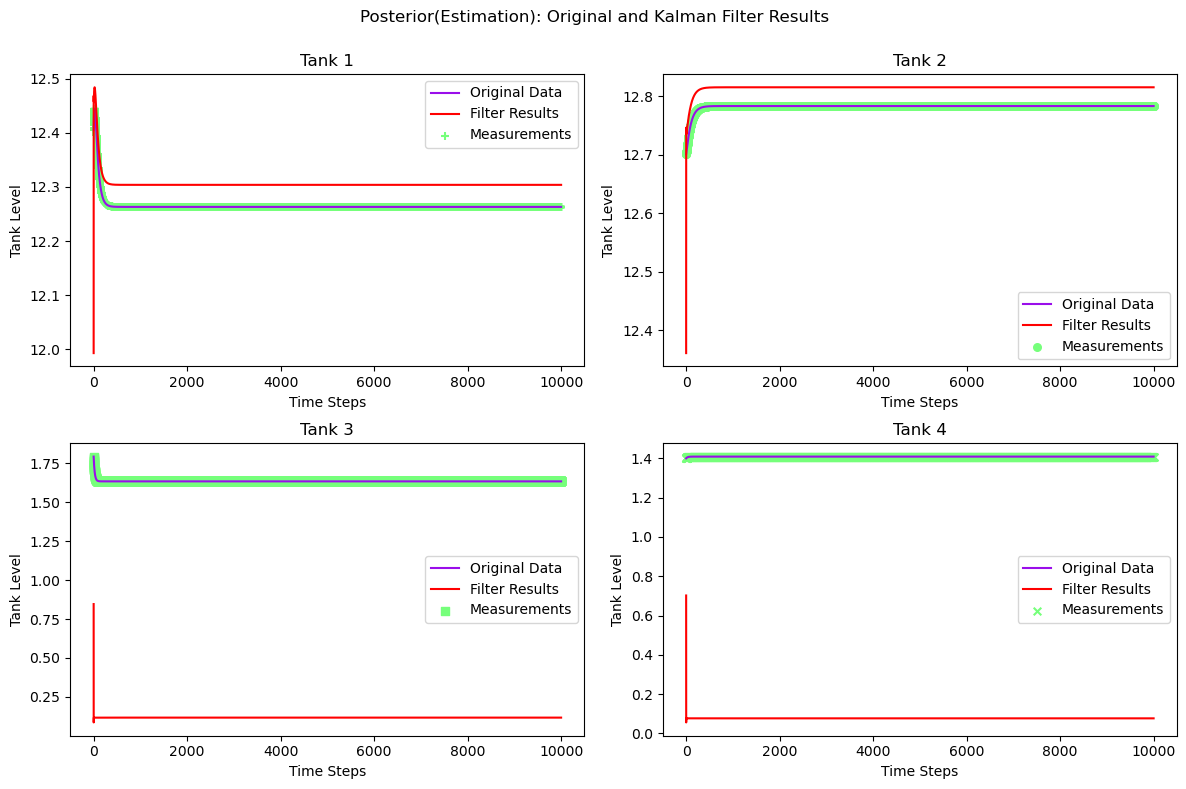

In [17]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[1:], X_post_list_loop[1:, 0], tank1_measurements[1:], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[1:], X_post_list_loop[1:, 1], tank2_measurements[1:], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[1:], X_post_list_loop[1:, 2], tank3_measurements[1:], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[1:], X_post_list_loop[1:, 3], tank4_measurements[1:], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Conclusion based upon the graphical result arrived after tuning the process noise covariance value : 
- However, upon analyzing the results from the above plotted graph, it has become evident that while the selected hyperparameter value of 8 produces accurate estimations for Tank 1 and Tank 2, it does not yield satisfactory results for Tank 3 and Tank 4. Therefore, further verification and optimization steps are required to improve the estimation accuracy for these particular tanks.

- The next steps involve examining the underlying dynamics of Tank 3 and Tank 4 more closely. By analyzing their behavior and identifying potential sources of discrepancy, we can refine the hyperparameter selection and modify the process noise covariance matrix accordingly. This iterative process aims to optimize the estimation performance of the Kalman filter for all four tanks in the 4 tank classic problem.

##### To improve the accuracy of the posterior estimation specifically for Tank 3 and Tank 4, I have made slight modifications to the process noise covariance matrix as follows,

- The intuition behind this modification is based on the fact that interconnected relationship of each tank. By considering this interconnectedness, I have updated the corresponding positions in the process noise covariance matrix. Instead of assigning a value of 0, I have assigned a value of 1.

- By doing so, the Kalman filter is empowered to make use of this information during the estimation process. It strives to bring the estimations of Tank 3 and Tank 4 closer to their actual values, in addition to the estimations for Tank 1 and Tank 2.

- This adjustment allows for a more sophisticated estimation approach, taking into account the interconnected nature of the tanks. As a result, the overall estimation accuracy and reliability of the Kalman filter for the 4 tank  problem are enhanced.

In [18]:
process_noise_cov_updated = 8 * np.eye(num_tanks)
process_noise_cov_updated[2,1] = process_noise_cov_updated[3, 0] = process_noise_cov_updated[0,3] = process_noise_cov_updated[1,2] = process_noise_cov_updated[2,2] = process_noise_cov_updated[3,3] = 1
print(f'process_noise_cov : {process_noise_cov_updated}')
X_post_list_loop, X_prior_list_loop, P_post_list_loop, P_pri_list_loop, Kalman_gain_list_loop, Measurement_error_loop = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov_updated, measurement_noise_cov, initial_error_covariance, initial_state)

process_noise_cov : [[8. 0. 0. 1.]
 [0. 8. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]]
Posterior states: [12.32599798 12.83327561  1.66342392  1.56520151]


In [19]:
X_post_list_loop = np.array(X_post_list_loop)
X_prior_list_loop = np.array(X_prior_list_loop)
P_post_list_loop = np.array(P_post_list_loop)
P_pri_list_loop = np.array(P_pri_list_loop)
Kalman_gain_list_loop = np.array(Kalman_gain_list_loop)

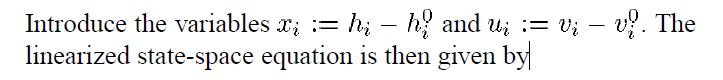

In [20]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_list_loop[:, 0] + h[0])}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_list_loop[:, 1] + h[1])}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_list_loop[:, 2] + h[2])}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_list_loop[:, 3] + h[3])}')

Tank 1 : Prior Estimate : 12.522667371056746
Tank 2 : Prior Estimate : 12.7984980114899
Tank 3 : Prior Estimate : 1.874028371863514
Tank 4 : Prior Estimate : 1.4415288311863206


###### Prior plots with entire data

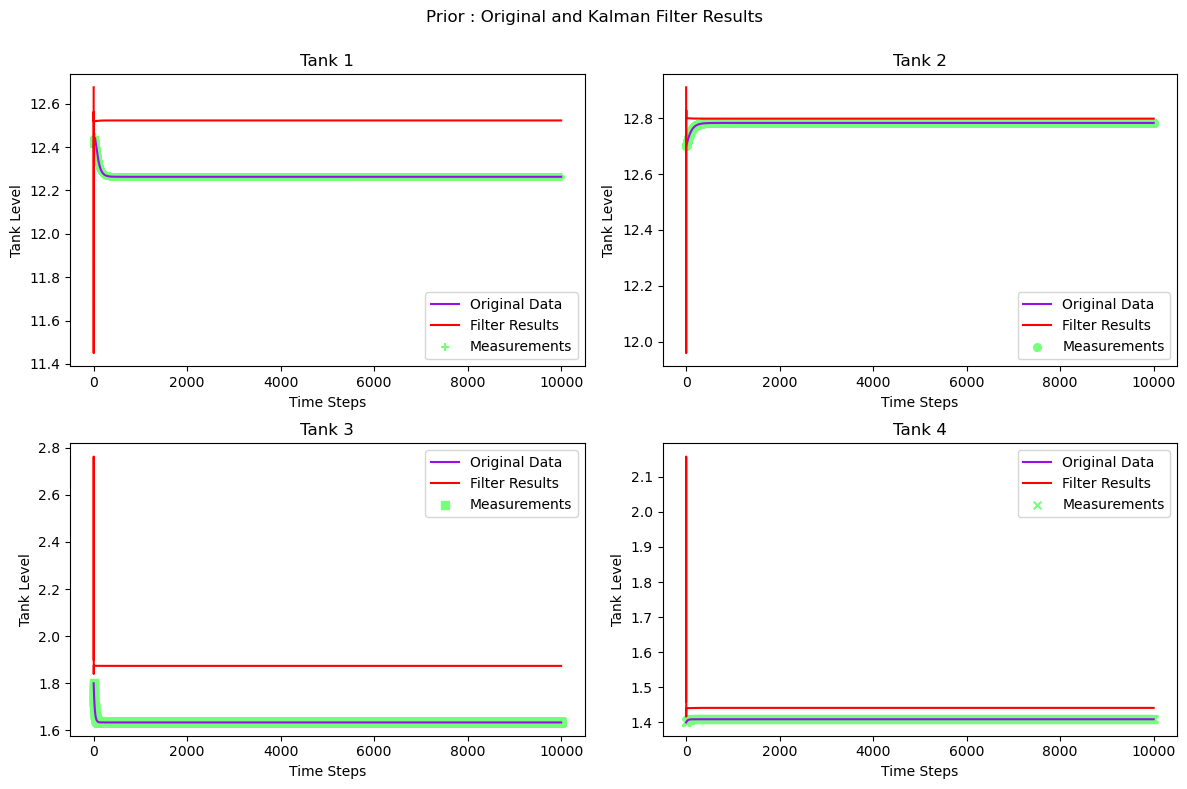

In [21]:
# Initialize the plot for Prior : Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_prior_list_loop[:, 0] + h[0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_prior_list_loop[:, 1] + h[1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_prior_list_loop[:, 2] + h[2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_prior_list_loop[:, 3] + h[3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [22]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_post_list_loop[:, 0])}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_post_list_loop[:, 1])}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_post_list_loop[:, 2])}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_post_list_loop[:, 3])}')

Tank 1 : Posterior Estimate : 12.328972889077397
Tank 2 : Posterior Estimate : 12.83353146968779
Tank 3 : Posterior Estimate : 1.6612816996404474
Tank 4 : Posterior Estimate : 1.5633538551789496


###### Posterior plots with entire data

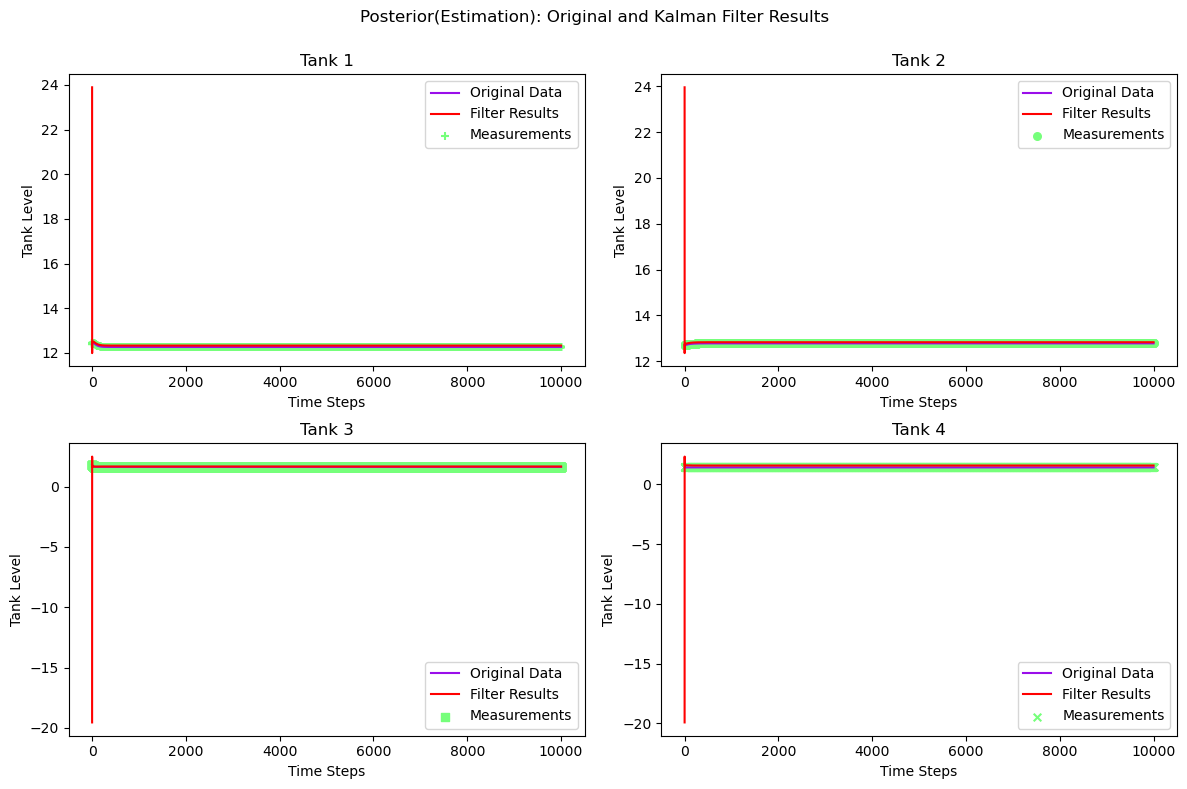

In [23]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_post_list_loop[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_post_list_loop[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_post_list_loop[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_post_list_loop[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Posterior plot after removing the first measurement to visualize the variation much closely

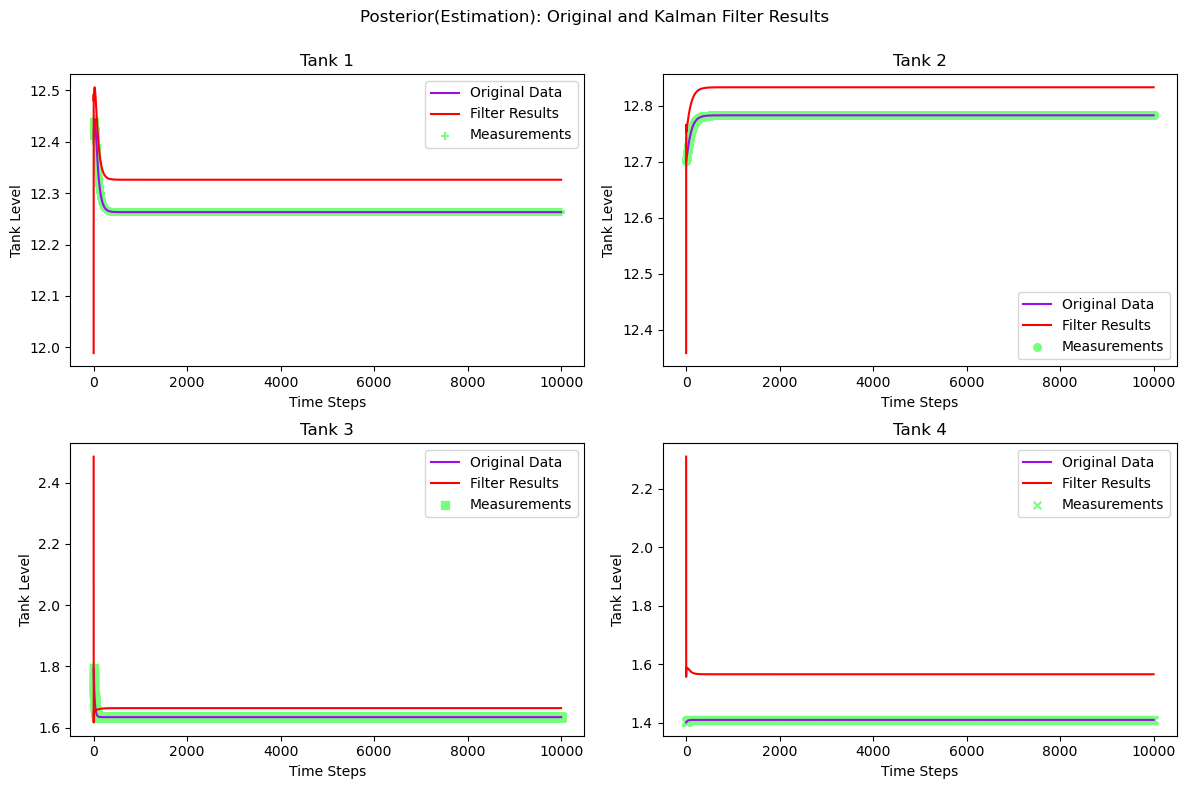

In [24]:
# Initialize the plot for Posterior(Estimation): Original and Kalman Filter Results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior(Estimation): Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps_10000, tank1_measurements[1:], X_post_list_loop[1:, 0], tank1_measurements[1:], 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps_10000, tank2_measurements[1:], X_post_list_loop[1:, 1], tank2_measurements[1:], 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps_10000, tank3_measurements[1:], X_post_list_loop[1:, 2], tank3_measurements[1:], 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps_10000, tank4_measurements[1:], X_post_list_loop[1:, 3], tank4_measurements[1:], 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Conclusion based upon the graphical result arrived after applying the new process noise covariance value : 
- Upon reviewing the posterior plot of the 4-tank implementation of the Kalman filter, it is evident that in the previous setup, satisfactory results were achieved only for Tank 1 and Tank 2. However, in the subsequent modification, significant improvements were observed in the estimation accuracy for Tank 3 and Tank 4 over the course of 10,000 timesteps. This enhancement demonstrates the effectiveness of the updated process noise covariance matrix [[8. 0. 0. 1.], [0. 8. 1. 0.], [0. 1. 1. 0.], [1. 0. 0. 1.]]. 

##### Different graphical plots for Kalman Filter

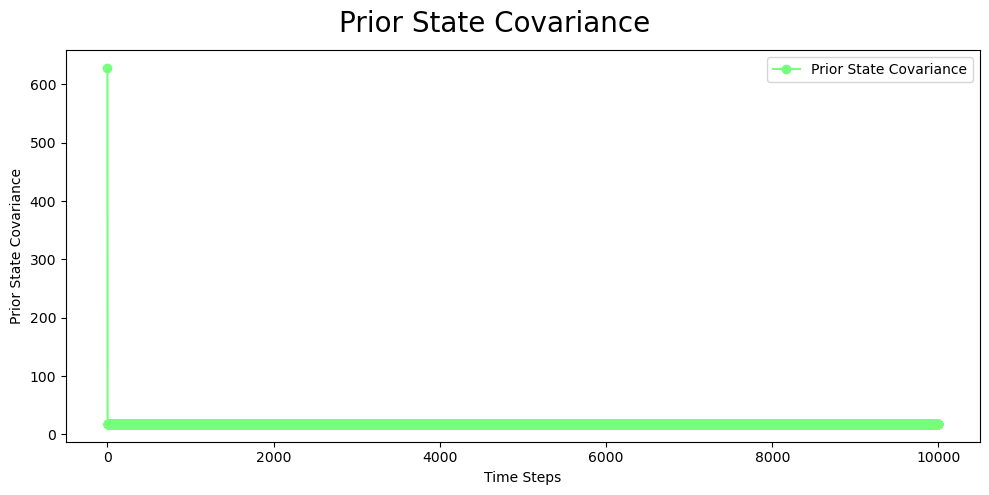

In [25]:
# Initialize the plot for Prior State Covariance
plotSingularData(1, time_steps, P_pri_list_loop, 'o', 'Prior State Covariance','#76FF7B')
# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

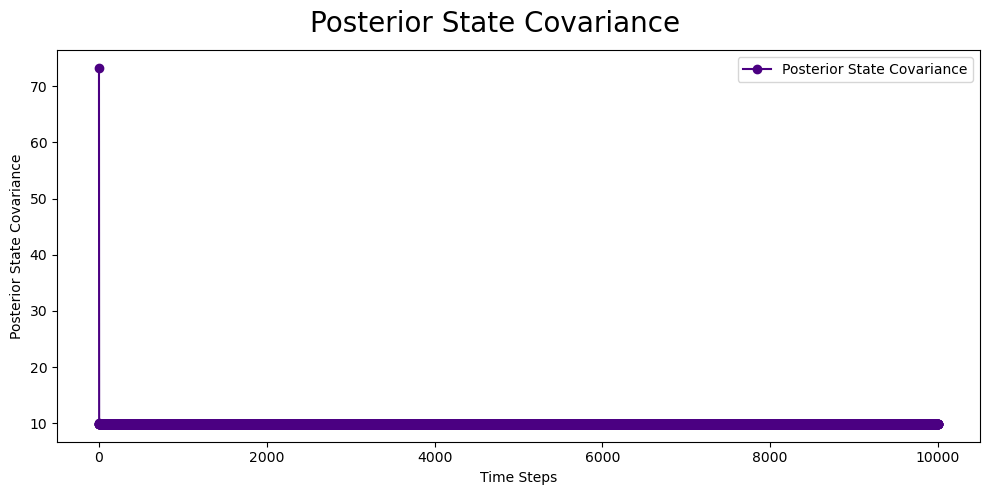

In [26]:
# Initialize the plot for Posterior State Covariance
plotSingularData(1, time_steps, P_post_list_loop, 'o', 'Posterior State Covariance','#4B0082')
# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

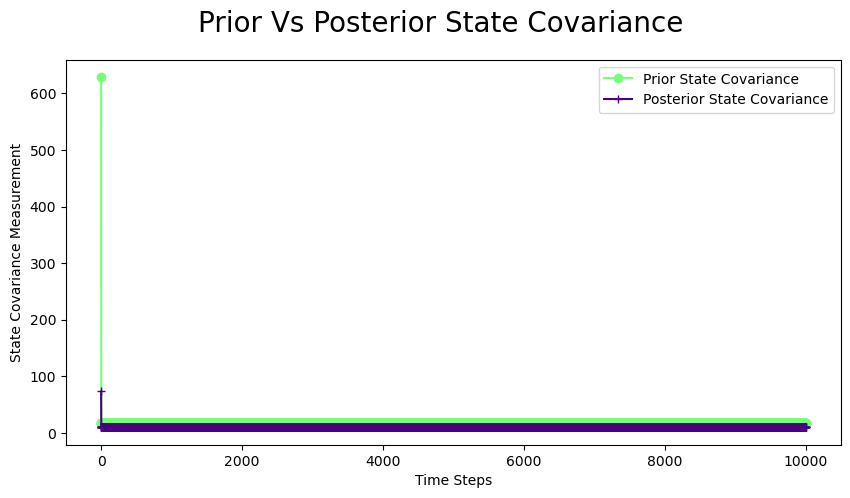

In [27]:
plt.figure(figsize=(10, 5))
plt.suptitle('Prior Vs Posterior State Covariance', fontsize = '20')
# Create a subplot for the current tank
plt.subplot(1, 1, 1) 
plt.plot(time_steps, P_pri_list_loop, label='Prior State Covariance', color='#76FF7B', marker='o') 
plt.plot(time_steps, P_post_list_loop, label='Posterior State Covariance', color='#4B0082', marker='+') 
# Set the x-axis label
plt.xlabel('Time Steps')  
# Set the y-axis label
plt.ylabel('State Covariance Measurement') 
# Show the legend
plt.legend()
plt.show()

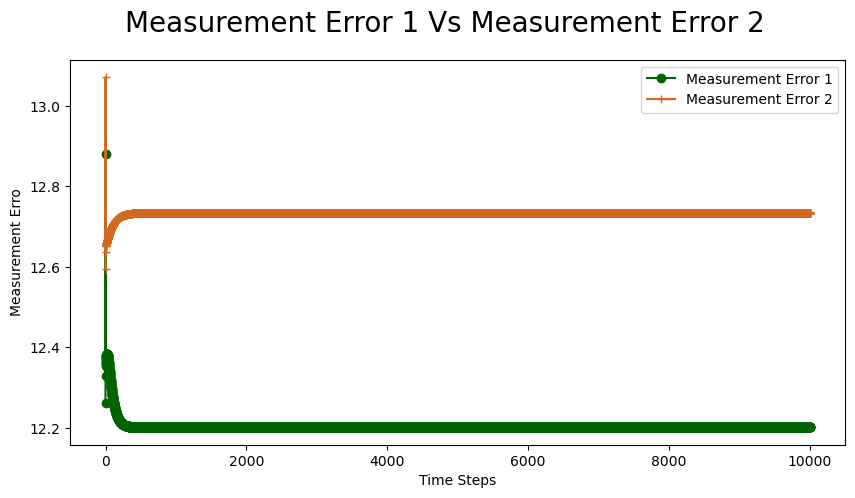

In [28]:
plt.figure(figsize=(10, 5))
plt.suptitle('Measurement Error 1 Vs Measurement Error 2', fontsize = '20')
# Create a subplot for the current tank
plt.subplot(1, 1, 1) 
plt.plot(time_steps, np.array(Measurement_error_loop)[:,0], label='Measurement Error 1', color='#006400', marker='o') 
plt.plot(time_steps, np.array(Measurement_error_loop)[:,1], label='Measurement Error 2', color='#D2691E', marker='+') 
# Set the x-axis label
plt.xlabel('Time Steps')  
# Set the y-axis label
plt.ylabel('Measurement Erro') 
# Show the legend
plt.legend()
plt.show()

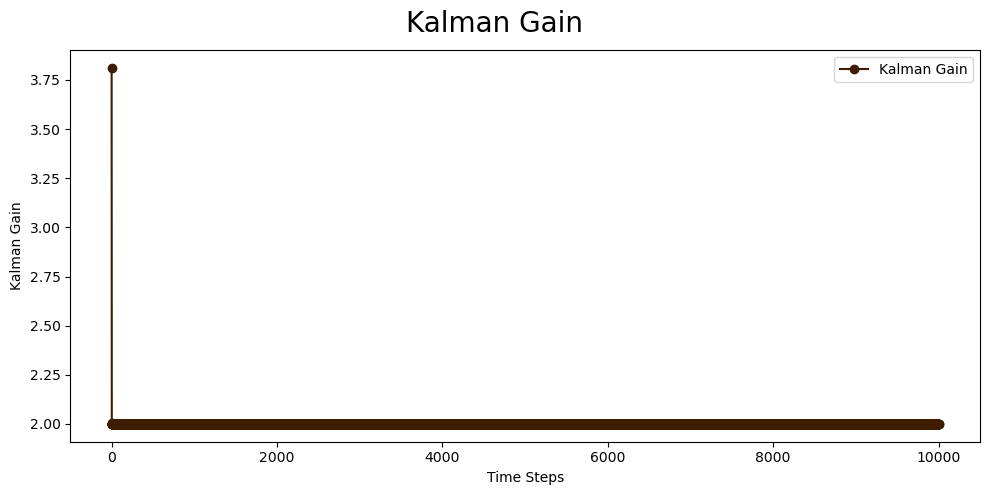

In [29]:
# Initialize the plot for Prior State Covariance
plotSingularData(1, time_steps, Kalman_gain_list_loop, 'o', 'Kalman Gain','#3D1C02')
# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

##### Kalman Filter Result

In [30]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'KalmanFilter_Tank1_Estimate': X_post_list_loop[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'KalmanFilter_Tank2_Estimate': X_post_list_loop[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'KalmanFilter_Tank3_Estimate': X_post_list_loop[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'KalmanFilter_Tank4_Estimate': X_post_list_loop[:, 3],
})

# Display the dataframe
display(results_dataframe)


,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate
0,0,12.400000,23.894577,12.700000,23.954857,1.800000,-19.551964,1.400000,-19.911428
1,1,12.404928,11.988740,12.700618,12.357942,1.792881,2.485029,1.400301,2.310184
2,2,12.409478,12.492546,12.701239,12.766437,1.786060,1.616665,1.400592,1.556114
3,3,12.413670,12.474422,12.701863,12.752186,1.779526,1.655159,1.400873,1.584643
4,4,12.417521,12.479223,12.702490,12.753367,1.773266,1.653557,1.401145,1.584054
...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9997,9997,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9998,9998,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202
9999,9999,12.262968,12.325998,12.783158,12.833276,1.633941,1.663424,1.409045,1.565202


#### Saving the compared data between Kalman and Particle Filter estimates

In [31]:
results_dataframe.to_csv('Comparison_Kalman.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion :**

###### Upon analyzing the observation values and estimated values below conclusion has arrived,  implemented Kalman filter, exhibits a noteworthy convergence towards the actual reading values for all four tanks. Initially, the values were deliberately chosen to be diverse, yet the Kalman filter demonstrates its efficacy by effectively converging these values. This convergence highlights the robustness and effectiveness of the Kalman filter in accurately estimating the true values of the tanks with modofied process noise covariance considering the fact of internal relation of different tank otherwise the convergence is not exactly accurate for Tank 3 & Tank 4.

<h3 style='text-align: center;'>=======================End of Mini Project Kalman Filter=======================</h3>